<a href="https://colab.research.google.com/github/Wpert/competitions/blob/main/spaceHack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://datsteam.dev/datsedenspace/statistics

Я вышел на 11 место! Жаль, что смог запустить рабочую версию алгоритма только к началу геймтона, потому решил не рисковать и не менять алгоритм решения задач...

Геймтон от DatsTeam на космическую тематику (точнее на графы и упаковку 2d фигур)

https://gamethon.datsteam.dev/datsedenspace/documentation/

Каковы планы? Пока не знаю, вряд ли я добьюсь гипер успеха на хакатоне, но можно постараться просто придумать решение для интересной задачи, набраться опыта при работе с API какого-нибудь чужого сервера. Одним полигоном от яндекс диска сыт не будешь. :)

Ниже приведены вспомогательные классы и функции для общего кода:

In [ ]:
import sys
from typing import Tuple, List, Dict
import typing
import requests
import json
import networkx as nx
import matplotlib.pyplot as plt

class Ship:
  def __init__(self, token: str, startPlanet: str):
    self._token = token
    self._header = {"X-Auth-Token" : token}
    self._currentPlanet = startPlanet
    self._infoURL = "https://datsedenspace.datsteam.dev/player/universe"
    self._travelURL = "https://datsedenspace.datsteam.dev/player/travel"
    self._collectURL = "https://datsedenspace.datsteam.dev/player/collect"
    self._info = {}
    self._hold = Hold()
    # nodes = list(PictureGraph.keys())

  def getCurrentPlanet(self) -> str:
    return self._currentPlanet

  def travelTo(self, destinationPlanet: str, printInfo=False) -> None:
    path = nx.shortest_path(self._G, self._currentPlanet, destinationPlanet)
    print(path)
    planets_path = path[1:]
    filename = f"{self._currentPlanet}_to_{destinationPlanet}.json"

    # print(planets_path)
    fly_path = {"planets" : planets_path}

    r = requests.post(self._travelURL, json.dumps(fly_path), headers=self._header)
    self._flyInfo = json.loads(r.text)

    if "error" in self._flyInfo.keys():
      print("error occured during flight")
      print(self._flyInfo["error"])
      return None
    if (destinationPlanet == "Eden"):
      self._hold.clear()
    self._currentPlanet = destinationPlanet

    # if "planetGarbage" in self._flyInfo.keys():
    #   self._planetsGarbage = self._flyInfo["planetGarbage"]
    #   print("planesGarbage renewed")

    if printInfo:
      with open(filename, "w") as fl:
        fl.write(r.text)
    # we can update info every time we travel

  def getPlanetGarbage(self):
    return self._planetsGarbage

  def collectGarbage(self) -> None:
    collected_garbage = {"garbage" : {}}

    for name, shape in self._planetsGarbage.items():
      status, new_shape = self._hold.setGarbageIn(shape)
      if status:
        collected_garbage["garbage"][name] = new_shape

    r = requests.post(self._collectURL, json.dumps(collected_garbage), headers=self._header)
    print(r.status_code)
    if (r.status_code != 200):
      kek = json.loads(r.text)
      print(json.dumps(kek, indent=4))

  def updateUniverseInfo(self) -> None:
    r = requests.get(self._infoURL, headers=self._header)
    if r.status_code != 200:
      print(r.text)
      return

    self._info = json.loads(r.text)
    self._currentPlanet = self._info["ship"]["planet"]["name"]
    self._planetsGarbage = self._info["ship"]["planet"]["garbage"]

    edgeList = self.getEdgeList()
    self._G = nx.DiGraph(directed=True)
    for from_, to_, weight_ in edgeList:
      self._G.add_edge(from_, to_, weight=weight_)

  def getEdgeList(self):
    return self._info["universe"]

  def getShipInfo(self):
    return self._info["ship"]

  def visualizeUniverse(self):
    plt.figure(figsize=(30, 25))
    # G = nx.Graph()
    # G = nx.DiGraph(directed=True)
    # G.add_edges_from(self.visual)

    color_map = []
    for node in self._G:
      if node == "Earth":
        color_map.append("green")
      elif node == "Eden":
        color_map.append("yellow")
      else:
        color_map.append("blue")

    nx.draw(self._G, node_color=color_map, with_labels=True)
    # plt.show()
    plt.savefig('universe.png')
    plt.savefig('universe.pdf')
  # def isAnyPlanet

  def findHamiltonianPath(self):
    if nx.is_tournament(self._G):
      return nx.tournament.hamiltonian_path(self._G)

  def findEulerianPath(self):
    if nx.is_eulerian(self._G):
      return nx.eulerian_circuit(self._G)

  def findEulerianCircuit(self):
    if nx.has_eulerian_path(self._G):
      return nx.eulerian_path(self._G)

  # def somePath(self):
  #   if nx.

In [ ]:
class Hold:
  def __init__(self):
    self._space = [[0] * 8 for i in range(11)]
    self._minX = 0
    self._minY = 0
    self._maxX = 8
    self._maxY = 11

  def clear(self):
    self._space = [[0] * 8 for i in range(11)]

  def checkIfCanPlace(self, coord: Tuple[int, int], shape) -> bool:
    x, y = coord
    for shape_block in shape:
      new_x = x + shape_block[0]
      new_y = y + shape_block[1]
      if new_x >= self._maxX or new_x < self._minX:
        return False

      if new_y >= self._maxY or new_y < self._minY:
        return False

      if self._space[new_y][new_x] == 1:
        return False

    return True

  def rotate(shape):
    y = len(shape)
    x = len(shape[0])

    rotatedMtrx = [[0] * y for i in range(x)]

    for i in range(y):
      for j in range(x):
        rotatedMtrx[j][i] = shape[y - 1 - i][j]

    rotated = []
    for i in range(y):
      for j in range(x):
        if (rotatedMtrx[i][j] == 1):
          rotated.append([i, j])

    return rotated

  def storeShape(self, shape, offset):
    x, y = offset
    for coords in shape:
      self._space[y + coords[1]][x + coords[0]] = 1

  def setGarbageIn(self, shape) -> bool:
    for x in range(self._maxX):
      for y in range(self._maxY):
        for rotate_times in range(4):
          rotated_shape = shape
          if self.checkIfCanPlace((x, y), rotated_shape):
            new_shape = []
            for block in rotated_shape:
              new_shape.append([block[0] + x, block[1] + y])

            self.storeShape(rotated_shape, (x, y))
            return True, new_shape

    return False, shape

  def printEverything(self):
    for layer in self._space:
      print(layer)


In [ ]:
token = "token"
starship = Ship(token, "some_planet")
# starship._info = space_dict
starship.updateUniverseInfo()
starship.getCurrentPlanet()

'Eden'

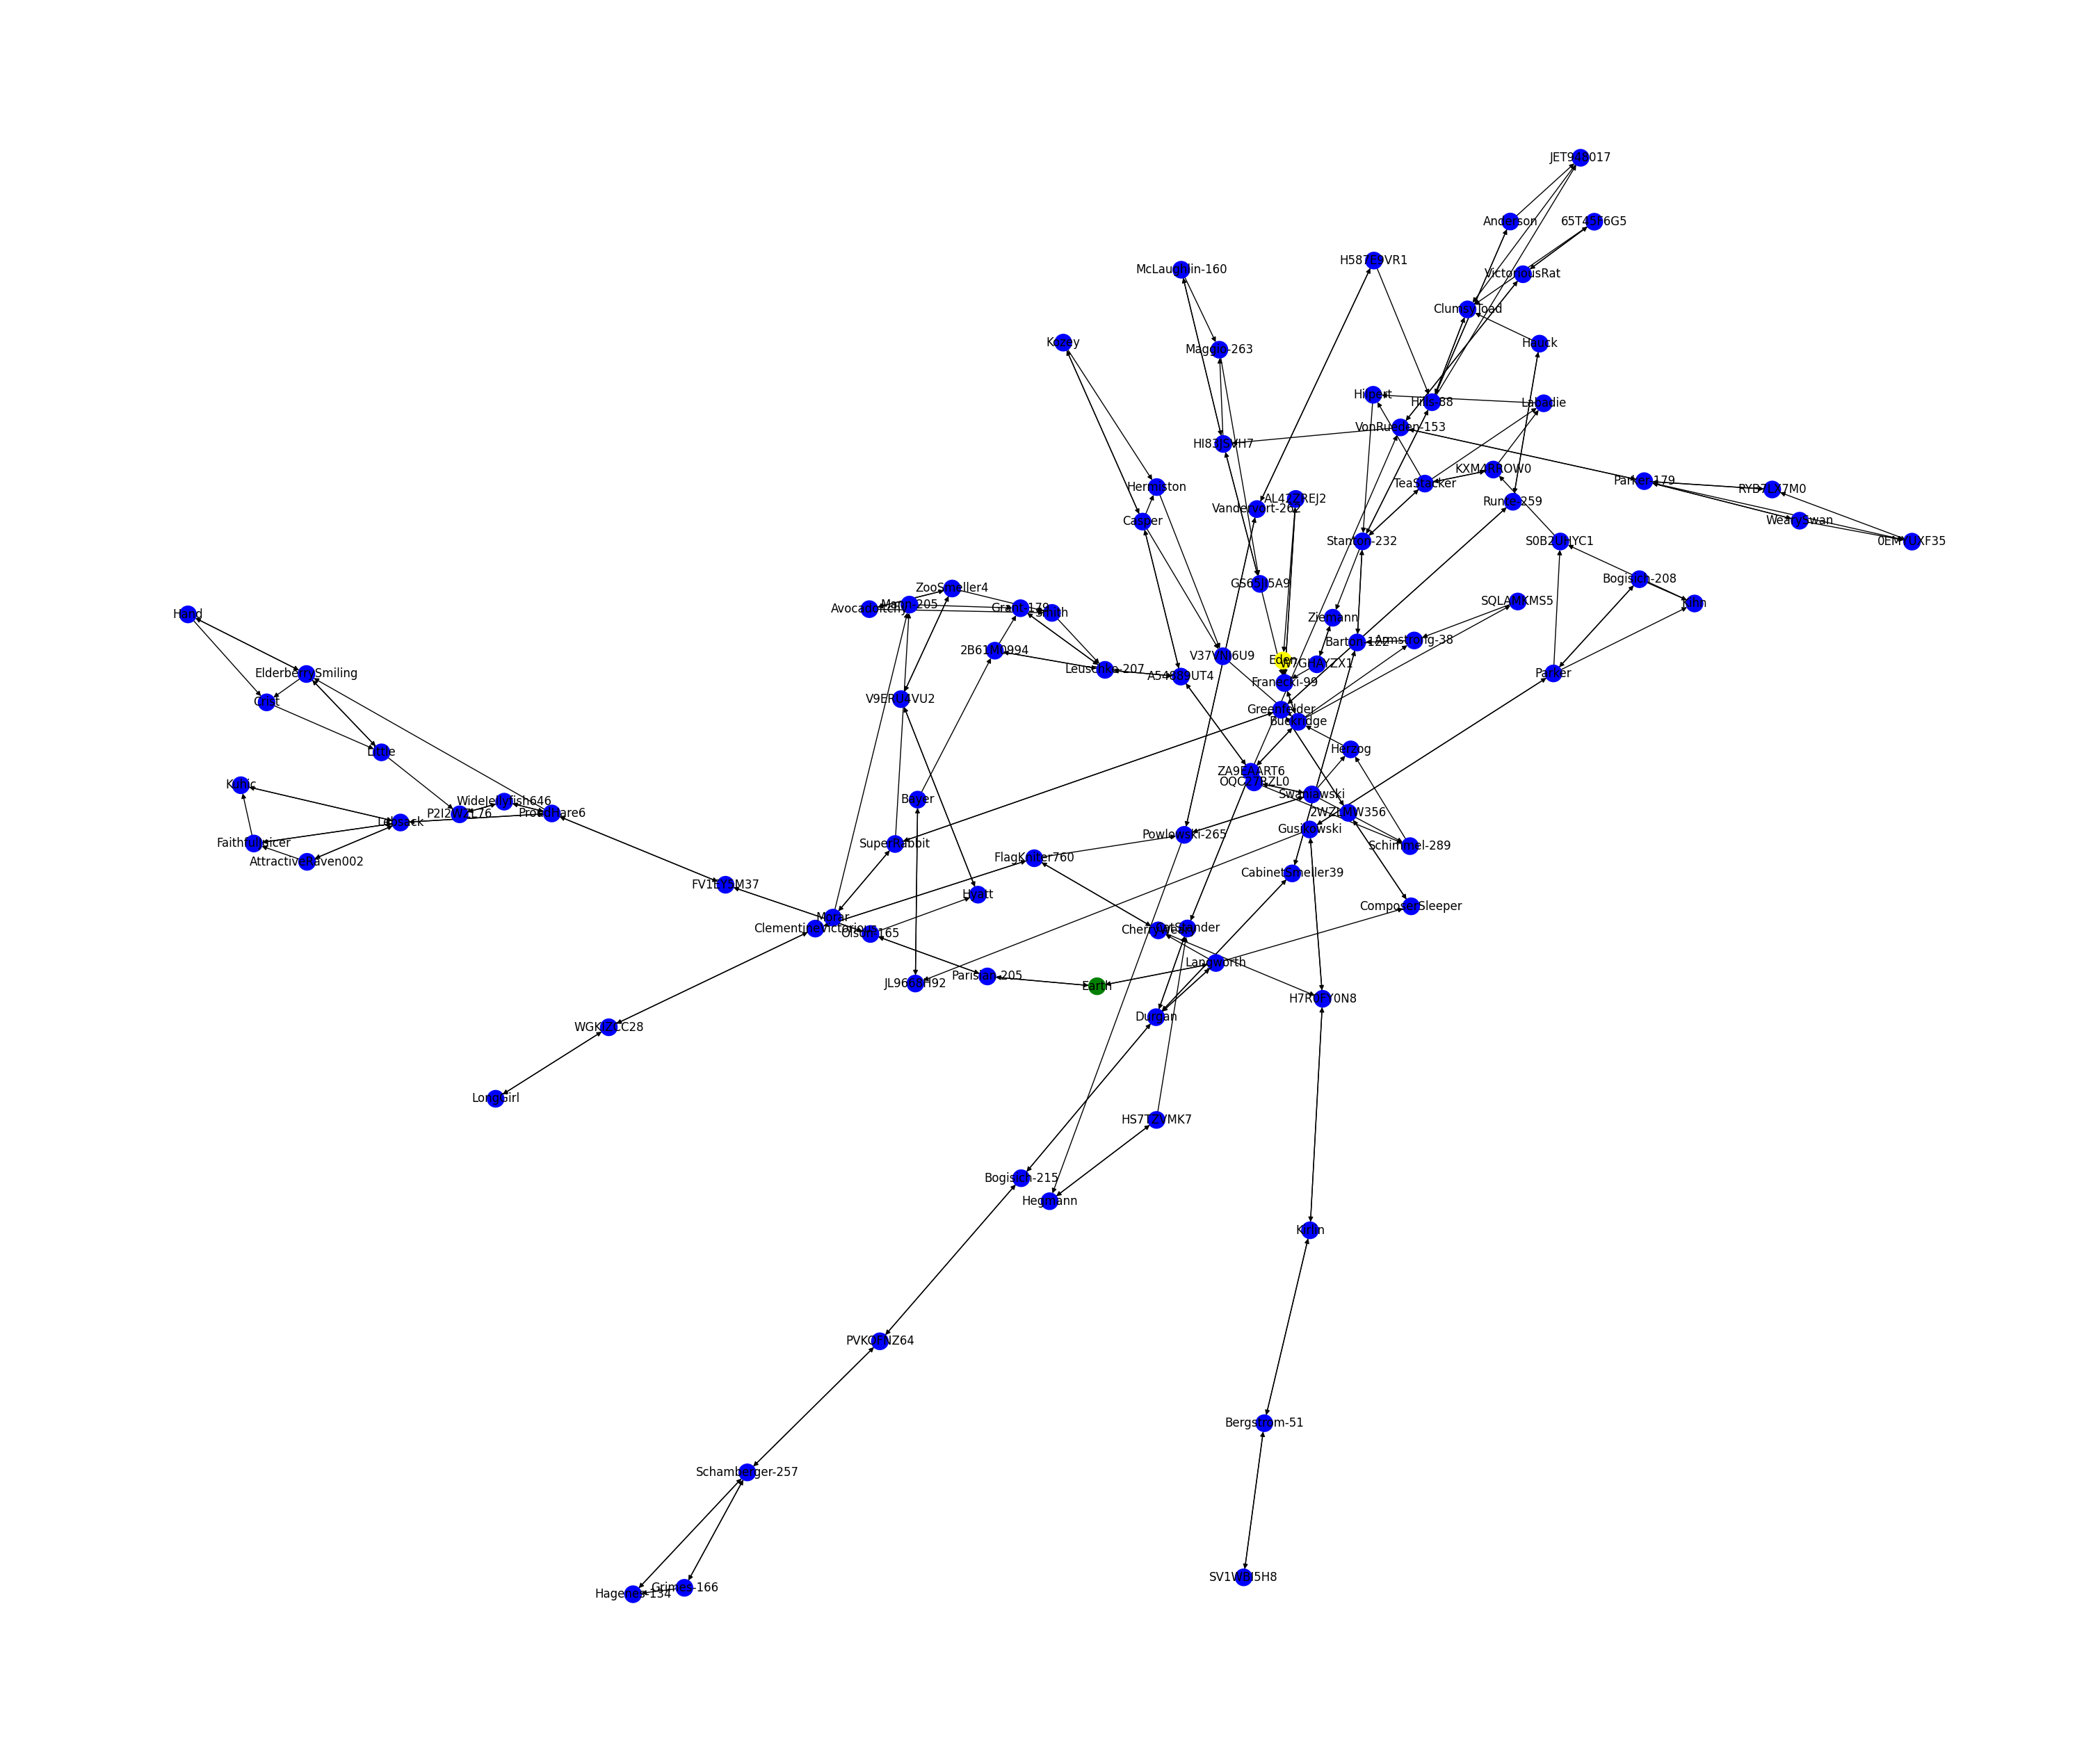

In [ ]:
starship.visualizeUniverse()

In [ ]:
starship.travelTo("Bartell", printInfo=False)

['ToughSnail', 'Earth', 'Ebert', 'Runolfsson-252', 'NU20VSB91', 'Bartell']
planesGarbage renewed


In [ ]:
if nx.has_eulerian_path(starship._G):
      print(nx.eulerian_path(starship._G))

In [ ]:
starship.collectGarbage()

200


In [ ]:
starship.travelTo("SY14A5781")

['Eden', 'Bartoletti', '6SYJMBDD5', 'Lebsack', 'HungryParrot', 'ToughSnail', 'Earth', 'Ebert', 'Runolfsson-252', 'NU20VSB91', 'SY14A5781']
planesGarbage renewed


In [ ]:
starship.updateUniverseInfo()

In [ ]:
starship.getPlanetGarbage()

{}

In [ ]:
starship._info

{'error': 'Round (Final 2) will start in 229 seconds'}

In [ ]:
print(json.dumps(starship.getPlanetGarbage(), indent=4))

{}


Ниже представлен код, чтобы очистить мусор со всех планет (к сожалению не очень оптимальный)

Работает следующим образом: создаём корабль, определяем его позицию в космосе, формируем карту по которой будем двигаться

И соответственно идём в такой цикл по всем планетам
- если на планете есть мусор
  - то летим на неё
  - собираем
  - улетаем на Eden

['HW0Q2H378', 'Schneider', '4YWNUP3O4', 'NectarineSore', 'Earth', '2R4W0D4R4']
200
['2R4W0D4R4', 'Kohler-106', 'Quigley-35', 'Stoltenberg', 'West', 'Eden']
['Eden', 'Gerhold', 'Bartoletti-57', 'Kohler-106', '2R4W0D4R4']
200
['2R4W0D4R4', 'Kohler-106', 'Quigley-35', 'Stoltenberg', 'West', 'Eden']
['Eden', 'Gerhold', 'Bartoletti-57', 'Kohler-106', '2R4W0D4R4']
200
['2R4W0D4R4', 'Kohler-106', 'Quigley-35', 'Stoltenberg', 'West', 'Eden']
['Eden', 'Gerhold', 'Bartoletti-57', 'Kohler-106', '2R4W0D4R4']
400
{
    "error": "field garbage is required"
}
['2R4W0D4R4', 'Kohler-106', 'Quigley-35', 'Stoltenberg', 'West', 'Eden']
PLANET 2R4W0D4R4 IS EMPTY!!!
['Eden', 'Gerhold', 'Mayer', 'Reichert-183', '2R4W0D4R4', 'Earth', 'NectarineSore']
200
['NectarineSore', 'Earth', '2R4W0D4R4', 'Kohler-106', 'Quigley-35', 'Stoltenberg', 'West', 'Eden']
['Eden', 'Gerhold', 'Mayer', 'Reichert-183', '2R4W0D4R4', 'Earth', 'NectarineSore']
200
['NectarineSore', 'Earth', '2R4W0D4R4', 'Kohler-106', 'Quigley-35', 'Sto

NodeNotFound: Either source Eden or target  is not in G

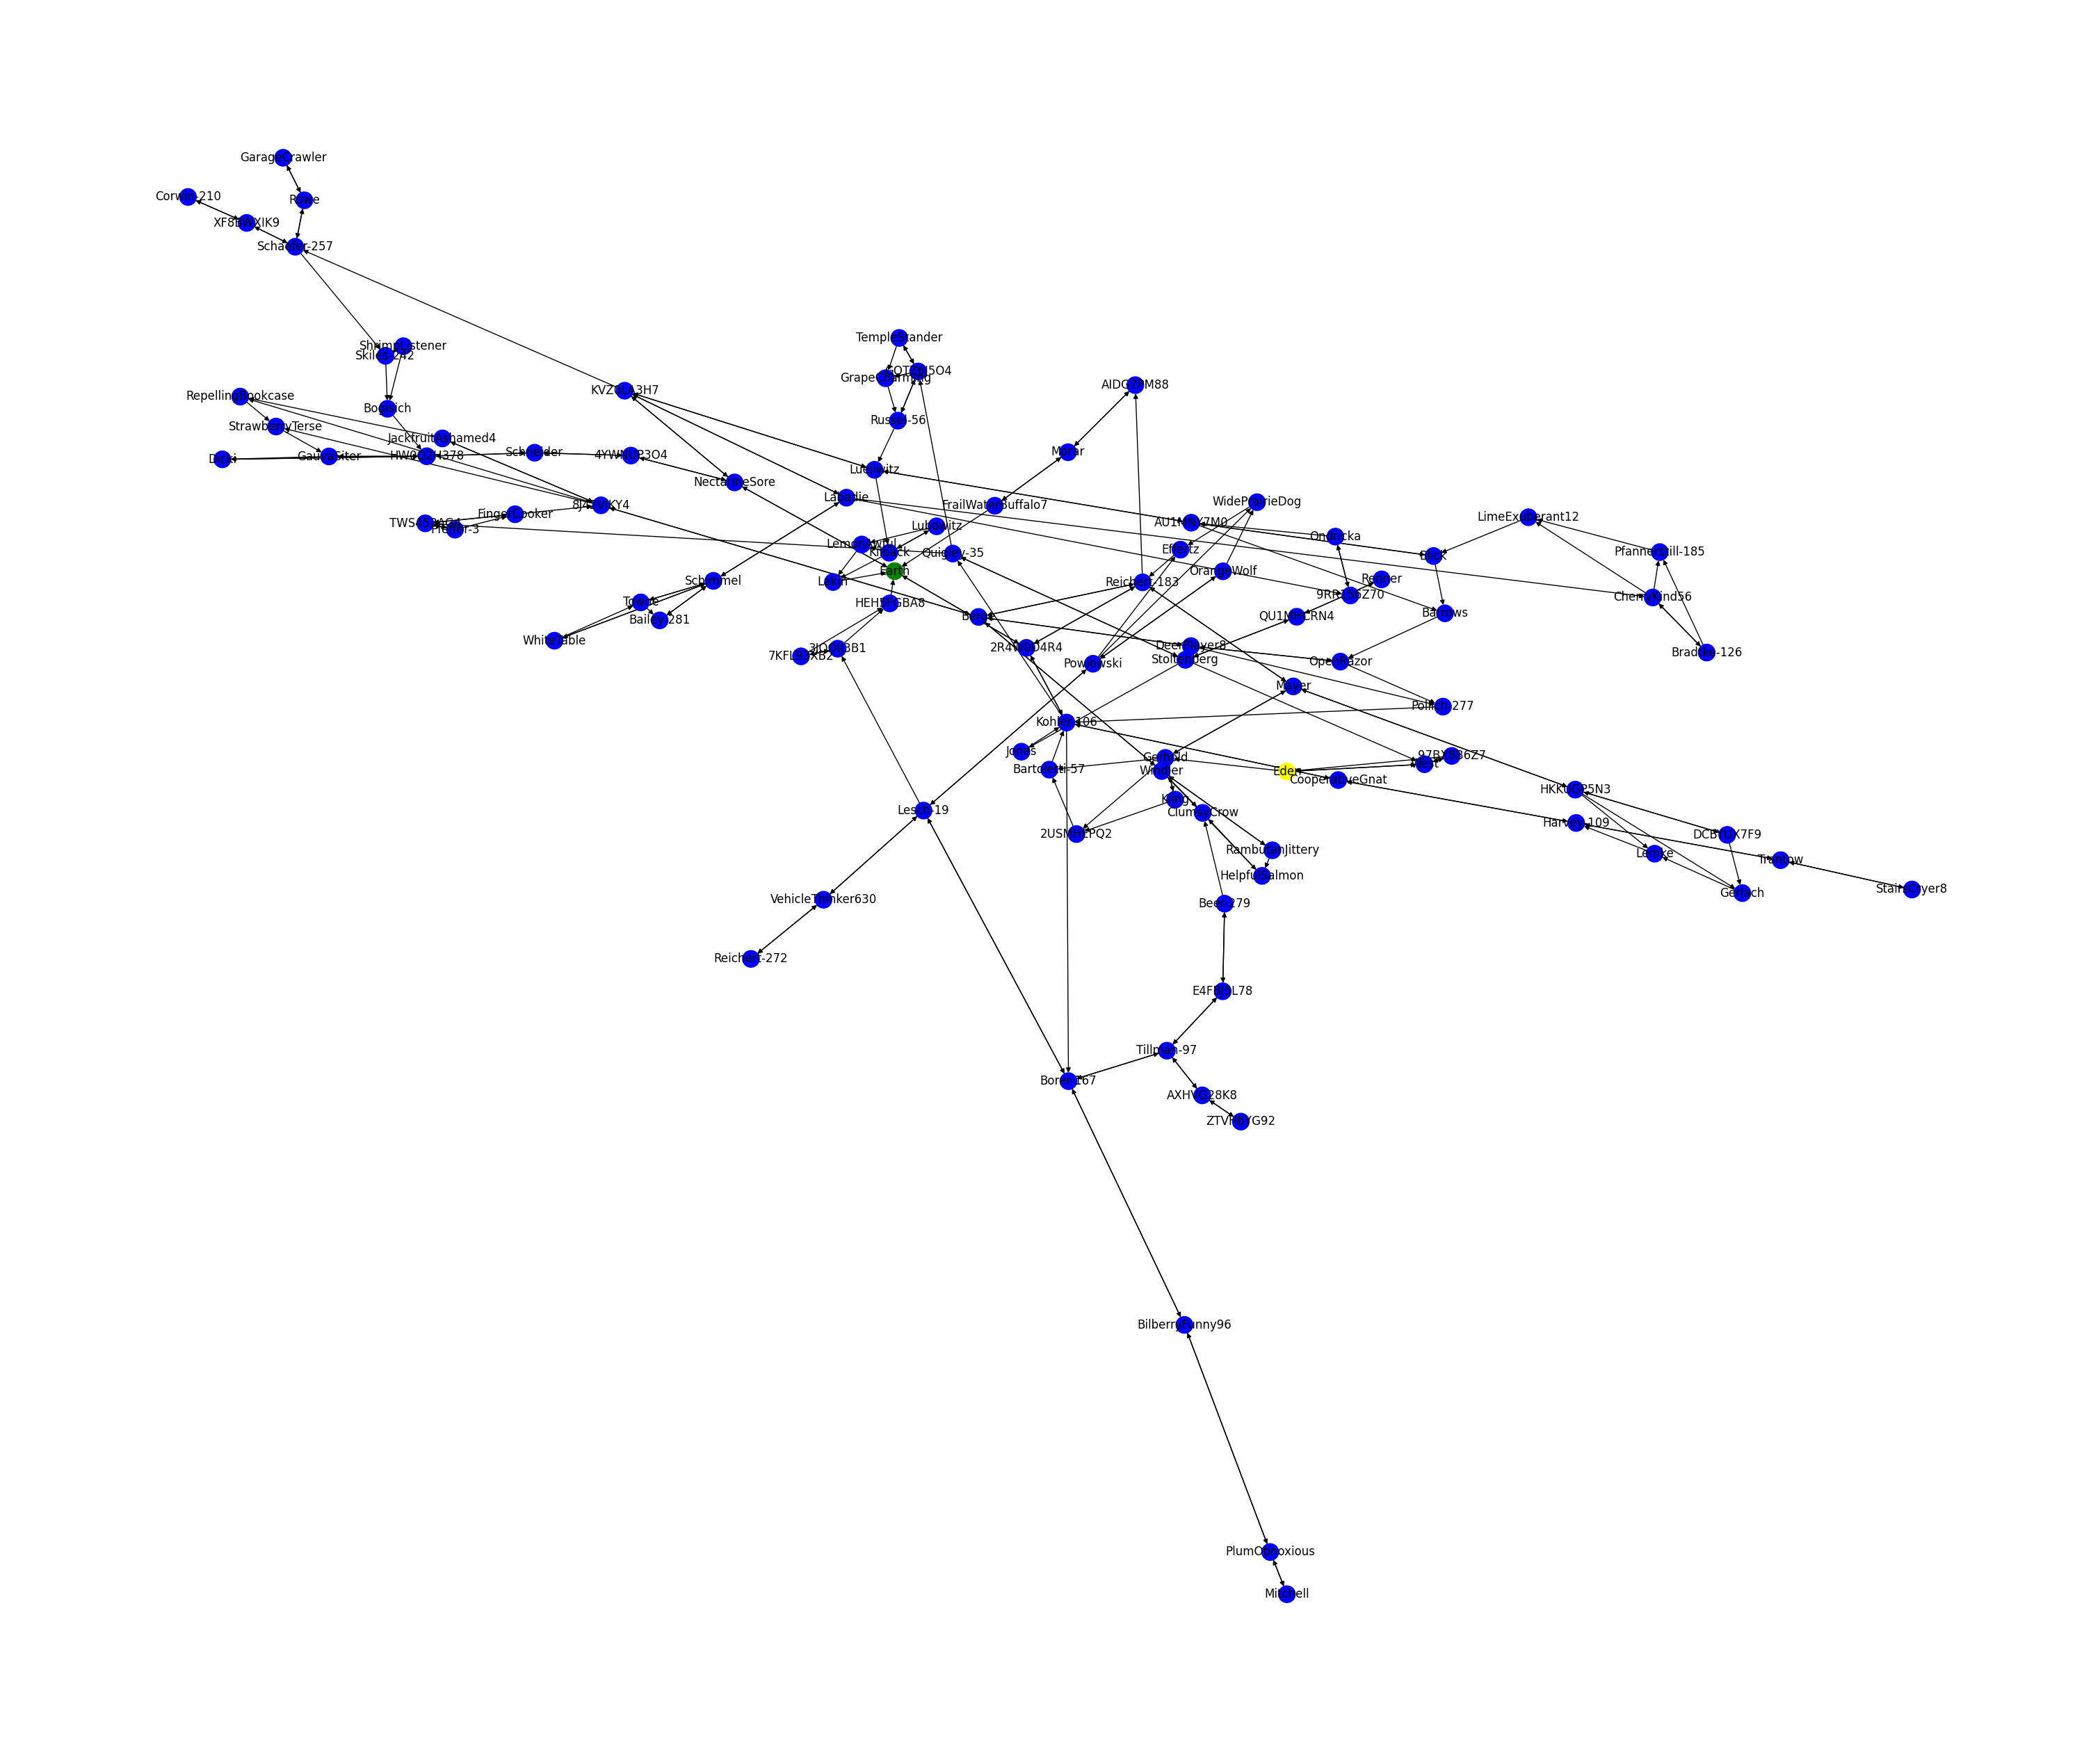

In [ ]:
token = "660bb812df0d2660bb812df0d5"
starship = Ship(token, "asassa")
# starship._info = space_dict
starship.updateUniverseInfo()
starship.getCurrentPlanet()

edgeList = starship.getEdgeList()
init_graph = {}
for from_, to_, weight in edgeList:
  init_graph[from_] = {}

planetStatus = {}
for planet in init_graph.keys():
  planetStatus[planet] = False

planetStatus["Earth"] = True
planetStatus["Eden"] = True

starship.visualizeUniverse()

while True:
  toPlanet = ""
  for planet, status in planetStatus.items():
    if (status == False):
      toPlanet = planet
      break

  if (toPlanet == ""):
    for planet in init_graph.keys():
      planetStatus[planet] = False
    planetStatus["Earth"] = True
    planetStatus["Eden"] = True

  starship.travelTo(toPlanet)
  starship.updateUniverseInfo()
  starship.collectGarbage()
  starship.travelTo("Eden")

  if starship.getPlanetGarbage() == {}:
    print (f"PLANET {toPlanet} IS EMPTY!!!")
    planetStatus[toPlanet] = True



Здесь я буду просто дурачиться, возможно зарабатывать ачивки

In [ ]:
token = "token"
starship = Ship(token, "some_planet")
# starship._info = space_dict
starship.updateUniverseInfo()
starship.getCurrentPlanet()

starship.travelTo("Eden")

edgeList = starship.getEdgeList()
init_graph = {}
for from_, to_, weight in edgeList:
  init_graph[from_] = {}

planetStatus = {}
for planet in init_graph.keys():
  planetStatus[planet] = False

planetStatus["Earth"] = True
planetStatus["Eden"] = True

for planet in init_graph.keys():
  starship.travelTo(planet)
  starship.collectGarbage()

['Earth', '2R4W0D4R4', 'Kohler-106', 'Quigley-35', 'Stoltenberg', 'West', 'Eden']
['Eden', 'Gerhold', 'Mayer', 'Reichert-183', '2R4W0D4R4', 'Earth']
400
{
    "error": "field garbage is required"
}
['Earth', '2R4W0D4R4']
400
{
    "error": "field garbage is required"
}
['2R4W0D4R4', 'Earth', 'NectarineSore']
400
{
    "error": "field garbage is required"
}
['NectarineSore', 'Earth', '2R4W0D4R4', 'Kohler-106']
400
{
    "error": "field garbage is required"
}
['Kohler-106', '2R4W0D4R4', 'Reichert-183']
400
{
    "error": "field garbage is required"
}
['Reichert-183', '2R4W0D4R4', 'Earth', 'NectarineSore', '4YWNUP3O4']
400
{
    "error": "field garbage is required"
}
['4YWNUP3O4', 'NectarineSore', 'KVZ0LA3H7']
400
{
    "error": "field garbage is required"
}
['KVZ0LA3H7', 'NectarineSore', 'Earth', '2R4W0D4R4', 'Kohler-106', 'CooperativeGnat']
400
{
    "error": "field garbage is required"
}
['CooperativeGnat', 'Kohler-106', 'Borer-167']
400
{
    "error": "field garbage is required"
}
['B

KeyboardInterrupt: 

Передаём на сервер GET запрос, чтобы получить информацию о раунде:
- Указываем " https://datsedenspace.datsteam.dev/player/universe "
- хедер делаем в виде " {"X-Auth-Token" : token} "

В ответ приходит JSON файл, с полями:
- "name" = имя команды
- "roundName" = имя раунда
- "roundEndIn" = время до конца раунда
- "ship" = словарь
  - "fuelUsed" = соклько топлива потратили всего
  - "planet" = словарь
    - "name" = имя текущей планеты
    - "garbage" = фигуры мусора
- "universe" = список ребер
  - с элементами вида [fromPlanet, toPlanet, fuelCost]

В этой части пора бы узнать как управлять нашим корабликом, перед нами стоит 2 задачи:
- Научиться летать сквозь пространство и время
- Научиться эффективно упаковывать вещи в трюм !!!

Тогда пройдёмся по каждой из задач:
Упаковывать в трюм - это NP-полная задача, решение которой я бы отдал сторонним библиотекам таким как libnest2d. При чем хотелось бы их увидеть на питоне!

Но первостепенно надо бы освоиться с API, например, научиться летать. Сформируем ниже запросы для полётов.
- сервер на " https://datsedenspace.datsteam.dev/player/travel "
- header всё также состомт из токена
- body = json файл {"planets" : [список планет для посещения]}

Запрос на сбор мусора



" https://datsedenspace.datsteam.dev/player/collect "

In [ ]:
starship.travelTo("Nitzsche")

['Eden', 'RaspberryTame878', 'GentlePig935', 'Howe', 'CourageousPark', 'Earth', 'Dickinson-191', 'BadImpala', 'KnightlyPig', 'Nitzsche']
error occured during flight
you have already completed the game


In [ ]:
token = "token"
starship = Ship(token, "some_planet")
# starship._info = space_dict
starship.updateUniverseInfo()
starship.getCurrentPlanet()

print(starship.findEulerianCircuit())
print(starship.findEulerianPath())
print(starship.findHamiltonianPath())

# starship.travelTo("Goodwin")

# starship.travelTo("42")
# starship.travelTo("Universe")
# starship.travelTo("The Universe")
starship.travelTo("The Ultimate Question of Life, the Universe, and Everything")

None
None
None
['Earth', 'UPQ2FEWM1', 'Hessel', 'JawWiner', 'ShampooCloseer', 'The Ultimate Question of Life, the Universe, and Everything']


In [ ]:
import requests
import json
from typing import List

def getCurrentPlanetDict():
  abc = requests.get(infoURL, headers=header)
  space_dict = json.loads(abc.text)
  currentPlanetDict = space_dict["ship"]["planet"]
  return currentPlanetDict

planetStatus = {}
for planet in nodes:
  planetStatus = False

# очищенные планеты
planetStatus["Earth"] = True
planetStatus["Eden"] = True

def getPlanet(planetStatusDict) -> bool:
  for planet, status in planetStatus:
    if status == False:
      return planet

  return "No planets avalieble"


Попытка провизуализировать "мусор" с планеты

import matplotlib.pyplot as plt

x = []
y = []

figure = [[0,3],[0,2],[0,1],[1,3],[1,1],[2,3],[2,1],[2,0],[3,3],[3,2],[3,1]]

for coord in figure:
  x.append(coord[0])
  y.append(coord[1])

plt.plot(x, y, "bs", markersize=40)

In [ ]:
import requests
import json

token = "token"
header = {"X-Auth-Token" : token}
infoURL = "https://datsedenspace.datsteam.dev/player/universe"

# abc: str = json.dumps(header)
r = requests.get(infoURL, headers=header)

code: int = r.status_code
# if code != 200:
#   print(json.dumps(json.loads(r.text), indent=4))
#   assert(False)

# ----------------------------------------

space_dict = json.loads(r.text)
# print(json.dumps(space_dict, indent=4))

PictureGraph = {}

currentPlanet = space_dict["ship"]["planet"]["name"]
edgeList = space_dict["universe"]
# [[from, to, weight], ...]

for from_, to_, weight_ in space_dict["universe"]:
  PictureGraph[from_] = []

nodes = list(PictureGraph.keys())

init_graph = {}
for node in nodes:
  init_graph[node] = {}

for from_, to_, weight_ in edgeList:
  init_graph[from_][to_] = weight_

  PictureGraph[from_].append(to_)

SpaceGraph = Graph(nodes, init_graph)

roundName = space_dict["roundName"]
timeEstimated = space_dict["roundEndIn"]
print(f"{roundName} ends in {timeEstimated}")

In [ ]:
with open("variables.json", "x") as fl:
  fl.write(json.dumps(space_dict, indent=5))

In [ ]:
# Convert Python to JSON
json_object = json.dumps(PictureGraph, indent = 4)

# Print JSON object
print(json_object)